Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

cell size in m:  16.406319924991898
25
25
Local coordinates (x,y) in px
[(12.0, 12.0), (12.0, 37.0), (12.0, 62.0), (12.0, 87.0), (37.0, 87.0), (37.0, 62.0), (37.0, 37.0), (37.0, 12.0), (62.0, 12.0), (62.0, 37.0)]


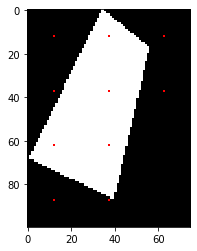

Local coordinates (x,y) in m
[(6.0, 6.0), (6.0, 18.5), (6.0, 31.0), (6.0, 43.5), (18.5, 43.5), (18.5, 31.0), (18.5, 18.5), (18.5, 6.0), (31.0, 6.0), (31.0, 18.5)]


In [6]:
from ipyleaflet import *
from ipywidgets import Layout, IntSlider
import geojson
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pyproj as proj
from tqdm import tqdm
import time

def global2local2(point, ref_point):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic coordinate system

    # Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(ref_point[1], ref_point[0]))
    x, y = proj.transform(crs_wgs, cust, point[0], point[1])
    return x,-y                     # Multiply by a minus because the latitude is higher the more "up" you go


def local2global(point, ref_point):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic coordinate system

    # Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(ref_point[1], ref_point[0]))
    lon, lat = proj.transform(cust, crs_wgs, point[0], -point[1])
    return lat, lon



def waypoints(coordinates,cam_fov_deg, height, overlap,pixel_size=0.5,debug_results=False):
    '''
    :param coordinates: list of global coordinates for the map, corners of the area.
     List of tuples of lat long. [(lat_1,lon_1),...(lat_n,lon_n)]
    :param cam_fov_deg: Field of view of the camera
    :param height: Height
    :param overlap:
    :param pixel_size
    :return: waypoints Tuple of lat long [(lat_1,lon_1),...(lat_n,lon_n)] in global form.
    '''

    cam_fov = math.radians(cam_fov_deg / 2)

    # Initialisation of latitude longitude
    lat_max = coordinates[0][1]
    lat_min = coordinates[0][1]
    lon_max = coordinates[0][0]
    lon_min = coordinates[0][0]

    for coordinate in coordinates:
        if coordinate[0] > lon_max:
            lon_max = coordinate[0]

        elif coordinate[0] < lon_min:
            lon_min = coordinate[0]

        if coordinate[1] > lat_max:
            lat_max = coordinate[1]

        elif coordinate[1] < lat_min:
            lat_min = coordinate[1]

    dlat = lat_max - lat_min
    dlon = lon_max - lon_min

    Global2local = global2local2((lon_max, lat_min), (lon_min, lat_max))
    dx = Global2local[0]/pixel_size
    dy = Global2local[1]/pixel_size
    #print('Global2Local = ', Global2local)

    # Create grid cell sizes with overlap 0.5
    cell_size_x = (math.tan(cam_fov) * height * (1-overlap)*2)/pixel_size
    cell_size_x=int(round((cell_size_x/4)*3))
    cell_size_y = cell_size_x
    print('cell size in m: ',(math.tan(cam_fov) * height * (1-overlap)*2))
    print(cell_size_x)
    print(cell_size_y)

    # Number of cells in the grid
    n_grids_x = np.ceil(dx / cell_size_x)
    n_grids_y = np.ceil(dy / cell_size_y)

    #print('Number of grids in X = ', n_grids_x)
    #print('Number of grids in Y = ', n_grids_y)

    n_grids_total = n_grids_x * n_grids_y
    #print('Total number of grids = ', n_grids_total)

    # Create a map of zeros
    map_array = np.zeros((int(cell_size_y*n_grids_y), int(cell_size_x*n_grids_x)))
    if debug_results:
        photo_area_map=np.zeros_like(map_array)

    coordinates_rel = []
    ref_point = (lon_min, lat_max)          # We start at top left

    # Create the local coordinates vector for the real coordinates gotten from GUI.
    for coordinate in coordinates:
        coordinates_rel.append(np.ceil(np.array(global2local2(coordinate, ref_point))/pixel_size).astype('int'))
    # Transform to array (N by 2)
    coord_rel_np = np.array(coordinates_rel)

    pts = coord_rel_np.reshape((-1, 1, 2))
    #print(pts)

    cv2.fillPoly(map_array, [pts], 1)
#    plt.imshow(map_array, cmap='gray')
#    plt.show()

    ''' Return center points of grid'''
    count_ones=0

    centers = []
    for j in range(int(n_grids_x)):
        centers_local = []                      # Variable to store inverted coordinates
        for i in range(int(n_grids_y)):
            patch_l = map_array[cell_size_y*i:cell_size_y*i+cell_size_y, cell_size_x*j:cell_size_x*j+cell_size_x]
            #print(patch_l)
            if patch_l.max() != 0:
                count_ones += np.sum(patch_l)

                # calculate center of patch. Should be length of lon + half of a patch size
                x_center = cell_size_x*j+cell_size_x*0.5
                y_center = cell_size_x*i+cell_size_x*0.5
                coords = (x_center-0.5, y_center-0.5)
                centers_local.append(coords)            # Store all the coordinates
                if debug_results:
                    photo_area_map[cell_size_y*i:cell_size_y*i+cell_size_y, cell_size_x*j:cell_size_x*j+cell_size_x]=1
        if j %2 != 0:                                   # If the y component is not divisible by 2
            centers_local.reverse()                     # Invert the list, so they are in decreasing order
        if centers_local != None:
            centers = centers + centers_local           # Store the final coordinate order for waypoint navigation


    print("Local coordinates (x,y) in px")
    print(centers)
    map_color = cv2.cvtColor((map_array*255).astype('uint8'),cv2.COLOR_GRAY2BGR)
    for center in centers:
        map_color[int(center[1]),int(center[0])] = (255,0,0)
    plt.imshow(map_color)
    plt.show()
    waypts_m=[]
    for center in centers:
        waypts_m.append((center[0]*pixel_size, center[1]*pixel_size))
    lonlat_wpts = []
    for waypt in tqdm(waypts_m,disable=True):
        lonlat_wpts.append(local2global(waypt, ref_point))
    print("Local coordinates (x,y) in m")
    print(waypts_m)

    #print("Global coordinates are (lon, lat):", lonlat_wpts)
    np.array(lonlat_wpts)

    with open('Waypoints.csv', 'w+') as f:
        for i in range(len(lonlat_wpts)):
            if i==0:
                f.write(str(lonlat_wpts[i][0])+',')
            else:
                f.write('\n'+str(lonlat_wpts[i][0])+',')
            f.write(str(lonlat_wpts[i][1])+',')
            f.write(str(height))
        #csv.writer(f).writerows(lonlat_wpts)
        
        
    if debug_results:
        with open('area_efficiency.txt', 'w+') as f:
            f.write(str(np.sum(photo_area_map)/np.sum(map_array))+'\n')
            f.write(str(np.sum(map_array)*pixel_size**2))
            f.close()
        
    return lonlat_wpts
        
        
    
    
    

def handle_draw(self, action, geo_json):
    #print(geo_json['geometry']['coordinates'][0])
    f = open("field.geojson", "w")
    time.sleep(0.1)
    wp=waypoints(geo_json['geometry']['coordinates'][0], 66.55, height_slider.value, 0.5, 0.5,debug_results=True)

    #create_waypoints(geo_json['geometry']['coordinates'][0],45,40,0.5)
    #print('Waypoints are: ', wp)
    #f.write(geojson.dumps(geo_json))
    f.close()
    line = Polyline(
    locations = [[
    wp,]],
    color = "blue",
    fill=False)
    
    
    layer_group = line
    
    for waypoint in wp:
        circle = Circle(
        location=waypoint,
        radius=1,
        color="red")
        layer_group=LayerGroup(
        layers=(layer_group,circle))
        
    m.add_layer(layer_group)
    
url = "https://api.mapbox.com/styles/v1/bedaberner/ck1dsr3tg1oq11cqp1zw2oilc/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiYmVkYWJlcm5lciIsImEiOiJjazFkc3BheTEwYXhtM2NxcHY3c2k2MTl1In0.G5Pr0yi-ssOvkm-KO1aEAw"
provider = TileLayer(url=url, opacity=1)
defaultLayout=Layout(width='1200px', height='840px')
m = Map(layers=(provider,),center=[57.014376, 9.969083], zoom=18, layout=defaultLayout,)

height_slider = IntSlider(description='Height: ', min=5,max=50,value=25)
widget_control = WidgetControl(widget=height_slider, position='topright')
m.add_control(widget_control)

draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 0.5
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

draw_control.on_draw(handle_draw)

m.add_control(draw_control)

m